In [1]:
!pip install xgboost matplotlib

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 13.0 MB/s eta 0:00:06
   --- ------------------------------------ 6.8/72.0 MB 25.0 MB/s eta 0:00:03
   --------- ------------------------------ 16.3/72.0 MB 33.4 MB/s eta 0:00:02
   -------------- ------------------------- 26.2/72.0 MB 38.0 MB/s eta 0:00:02
   ------------------- -------------------- 35.9/72.0 MB 39.9 MB/s eta 0:00:01
   ------------------------- -------------- 45.1/72.0 MB 40.1 MB/s eta 0:00:01
   ----------------------------- ---------- 53.5/72.0 MB 40.4 MB/s eta 0:00:01
   ---------------------------------- ----- 62.7/72.0 MB 40.6 MB/s eta 0:00:01
   ---------------------------------------  71.0/72.0 MB 40.8 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 38.5 MB/s  0:00:02


Start verwerking voor training_set_2024_2025.csv...
Stap 1: Feature Engineering...
Data opgeschoond. 11554 rijen overgebleven.
Stap 2: Definiëren Features (X) en Target (y)...
Stap 3: Data splitsen op 2025-01-01 00:00:00...
Trainingset: 4001 rijen
Testset: 7553 rijen
Stap 4: XGBoost Model trainen...
Model training voltooid.
Stap 5: Model evalueren...

--- RESULTAAT ---
Gemiddelde Fout (MAE): 0.0122
Dit betekent dat het model er gemiddeld 1.22 cent naast zat.
Stap 6: Plot genereren...


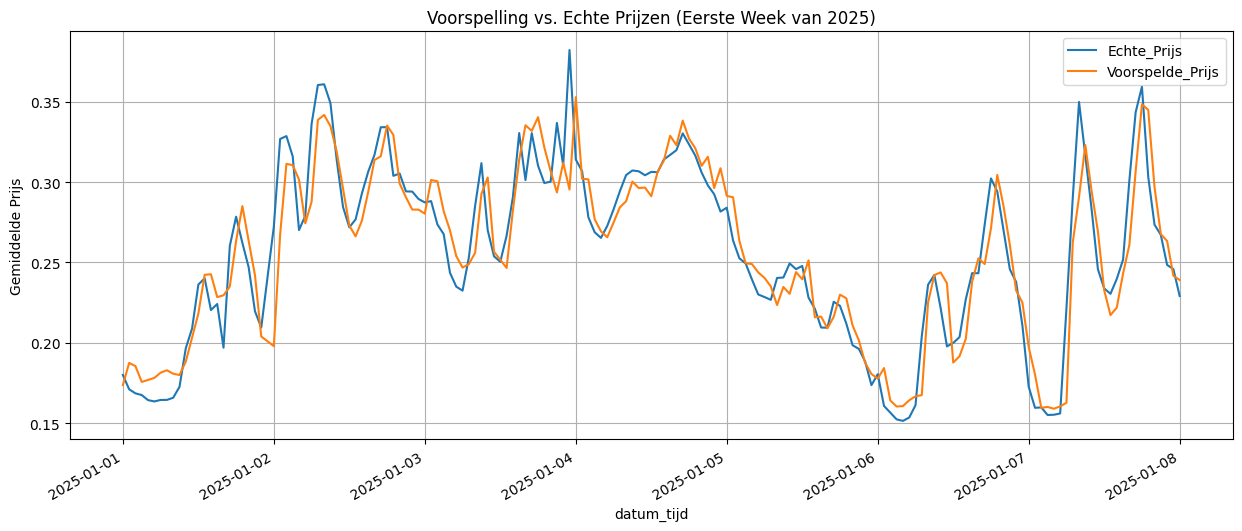

Stap 7: Belangrijkste Features tonen...

Belangrijkste features volgens het model:
prijs_1u_geleden     0.771534
prijs_24u_geleden    0.037891
uur_van_de_dag       0.027163
temp_avg_3u          0.021784
prijs_avg_6u         0.020315
dag_van_de_week      0.016608
wind_snelheid        0.016497
luchtdruk            0.014006
maand                0.013830
dag_van_het_jaar     0.012987
dtype: float32


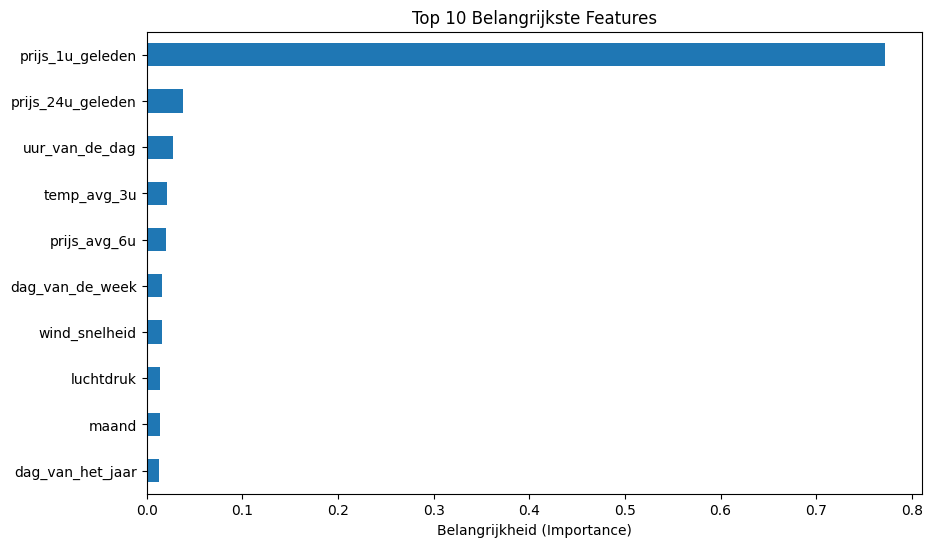


--- Analyse voltooid ---


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- CONFIGURATIE ---
bestandsnaam = 'training_set_2024_2025.csv'
split_datum = '2025-01-01 00:00:00'
TARGET = 'gemiddelde_prijs'

print(f"Start verwerking voor {bestandsnaam}...")

# --- STAP 1: DATA LADEN & FEATURE ENGINEERING ---
try:
    df = pd.read_csv(bestandsnaam)
except FileNotFoundError:
    print(f"FOUT: Bestand '{bestandsnaam}' niet gevonden.")
    # Stop de rest van het script als het bestand mist
    raise

print("Stap 1: Feature Engineering...")
df['datum_tijd'] = pd.to_datetime(df['datum_tijd'])
df = df.set_index('datum_tijd').sort_index() # Sorteer op datum en maak het de index

# Tijd-features
df['uur_van_de_dag'] = df.index.hour
df['dag_van_de_week'] = df.index.dayofweek
df['maand'] = df.index.month
df['dag_van_het_jaar'] = df.index.dayofyear

# Lag-features (historie)
df['prijs_1u_geleden'] = df[TARGET].shift(1)
df['prijs_24u_geleden'] = df[TARGET].shift(24)

# Rolling-features (trends)
df['temp_avg_3u'] = df['temperatuur'].rolling(window=3).mean()
df['prijs_avg_6u'] = df[TARGET].rolling(window=6).mean()

# Verwijder NaNs die door .shift() en .rolling() zijn ontstaan
df_clean = df.dropna()
print(f"Data opgeschoond. {len(df_clean)} rijen overgebleven.")

# --- STAP 2: DEFINIEER FEATURES (X) en TARGET (y) ---
print("Stap 2: Definiëren Features (X) en Target (y)...")
FEATURES = [col for col in df_clean.columns if col not in [TARGET]]

X = df_clean[FEATURES]
y = df_clean[TARGET]

# --- STAP 3: CHRONOLOGISCHE TRAIN-TEST SPLIT ---
print(f"Stap 3: Data splitsen op {split_datum}...")
train_mask = X.index < split_datum
test_mask = X.index >= split_datum

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Trainingset: {X_train.shape[0]} rijen")
print(f"Testset: {X_test.shape[0]} rijen")

# --- STAP 4: MODEL TRAINEN (XGBoost) ---
print("Stap 4: XGBoost Model trainen...")
# Dit is het model dat we wilden gebruiken
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,       # Max 1000 "bomen"
    learning_rate=0.01,      # Leer langzaam
    early_stopping_rounds=50 # Stop als de score 50 rondes niet verbetert
)

# Train het model en gebruik de testset om 'early stopping' toe te passen
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Zet op True (of 100) als je de voortgang wilt zien
)
print("Model training voltooid.")

# --- STAP 5: EVALUATIE ---
print("Stap 5: Model evalueren...")
# Genereer voorspellingen op de testset
voorspellingen = xgb_model.predict(X_test)

# Bereken de fout
mae = mean_absolute_error(y_test, voorspellingen)
print(f"\n--- RESULTAAT ---")
print(f"Gemiddelde Fout (MAE): {mae:.4f}")
print(f"Dit betekent dat het model er gemiddeld {mae*100:.2f} cent naast zat.")

# Maak een dataframe met de resultaten voor de plot
resultaten = pd.DataFrame({'Echte_Prijs': y_test, 'Voorspelde_Prijs': voorspellingen})

# --- STAP 6: VISUALISATIE (PLOT) ---
print("Stap 6: Plot genereren...")
# Plot de eerste week van de voorspellingen
resultaten.head(168).plot(figsize=(15, 6)) # 7 dagen * 24 uur = 168
plt.title('Voorspelling vs. Echte Prijzen (Eerste Week van 2025)')
plt.ylabel('Gemiddelde Prijs')
plt.grid(True)
plt.show() # Dit toont de grafiek direct in je notebook

# --- STAP 7: FEATURE IMPORTANCE ---
print("Stap 7: Belangrijkste Features tonen...")
# Wat vond het model het belangrijkst?
feature_importance = pd.Series(xgb_model.feature_importances_, index=FEATURES).sort_values(ascending=False)

print("\nBelangrijkste features volgens het model:")
print(feature_importance.head(10)) # Top 10

# Plot de feature importance
feature_importance.head(10).sort_values(ascending=True).plot(
    kind='barh', 
    figsize=(10, 6), 
    title='Top 10 Belangrijkste Features'
)
plt.xlabel('Belangrijkheid (Importance)')
plt.show() # Toont de grafiek

print("\n--- Analyse voltooid ---")

In [4]:
# Definieer de bestandsnaam
model_bestandsnaam = 'price_forecast_model.json'

# Sla het model op
# (De variabele 'xgb_model' bestaat nog van de vorige cel die je hebt gerund)
xgb_model.save_model(model_bestandsnaam)

print(f"Model succesvol opgeslagen als: {model_bestandsnaam}")
print("Je kunt nu het 'voorspel_prijzen.py' script uitvoeren.")

Model succesvol opgeslagen als: price_forecast_model.json
Je kunt nu het 'voorspel_prijzen.py' script uitvoeren.


In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb

# --- CONFIGURATIE ---
MODEL_FILE = 'price_forecast_model.json'
TARGET = 'gemiddelde_prijs'

# Dit zijn de features die het model MOET hebben (kopieer van je trainingsscript)
FEATURES = [
    'temperatuur', 'gevoelstemperatuur', 'neerslag', 'wind_richting', 
    'wind_snelheid', 'bewolking', 'luchtdruk', 'luchtvochtigheid', 
    'uur_van_de_dag', 'dag_van_de_week', 'maand', 'dag_van_het_jaar', 
    'prijs_1u_geleden', 'prijs_24u_geleden', 'temp_avg_3u', 'prijs_avg_6u'
]

print(f"Laden van model: {MODEL_FILE}")
# --- 1. Laad het getrainde model ---
model = xgb.XGBRegressor()
model.load_model(MODEL_FILE)
print("Model succesvol geladen.")


# --- 2. Verzamel de benodigde data ---
# Dit is de data die je "live" moet ophalen.
# We simuleren het nu, maar in de praktijk haal je dit uit je database of een API.

# Je hebt de data van de afgelopen 24 uur nodig voor de Lag/Rolling features
# (HIER GEBRUIKEN WE NEP-DATA TER ILLUSTRATIE)
print("Simuleren van recente historische data...")
historische_data = {
    'datum_tijd': pd.to_datetime(pd.date_range(end=pd.Timestamp.now(), periods=24, freq='h')),
    TARGET: np.random.uniform(0.15, 0.35, 24),
    'temperatuur': np.random.uniform(5, 15, 24)
}
hist_df = pd.DataFrame(historische_data).set_index('datum_tijd')


# ==============================================================================
# === HIER VUL JE DE ECHTE WEERSVOORSPELLING IN ===
# ==============================================================================
# Dit is de *toekomstige* weersvoorspelling die je van een API (KNMI, OpenWeather) haalt.
# We simuleren nu een voorspelling voor de komende 24 uur.
print("Simuleren van toekomstige weersvoorspelling (volgende 24u)...")

toekomstige_datums = pd.date_range(start=pd.Timestamp.now() + pd.Timedelta(hours=1), periods=24, freq='h')

simulated_forecast_df = pd.DataFrame({
    'datum_tijd': toekomstige_datums,
    'temperatuur': [10.1, 10.0, 9.8, 9.5, 9.2, 9.0, 8.8, 9.1, 10.2, 11.5, 12.0, 12.5, 13.0, 12.8, 12.0, 11.5, 11.0, 10.5, 10.2, 10.0, 9.8, 9.6, 9.4, 9.2],
    'gevoelstemperatuur': [7.1, 7.0, 6.8, 6.5, 6.2, 6.0, 5.8, 6.1, 7.2, 8.5, 9.0, 9.5, 10.0, 9.8, 9.0, 8.5, 8.0, 7.5, 7.2, 7.0, 6.8, 6.6, 6.4, 6.2],
    'neerslag': [0.0]*24,
    'wind_richting': [210]*24,
    'wind_snelheid': [18.0]*24,
    'bewolking': [80]*24,
    'luchtdruk': [1015]*24,
    'luchtvochtigheid': [90]*24,
}).set_index('datum_tijd')


# --- 3. Combineer historie en toekomst voor Feature Engineering ---
# We hebben de staart van de historie nodig om de 'lag' en 'rolling' features 
# voor de *eerste* toekomstige uren te berekenen.
combined_df = pd.concat([hist_df, simulated_forecast_df])

# --- 4. Pas EXACT dezelfde Feature Engineering toe ---
print("Feature Engineering toepassen op nieuwe data...")
# Tijd-features
combined_df['uur_van_de_dag'] = combined_df.index.hour
combined_df['dag_van_de_week'] = combined_df.index.dayofweek
combined_df['maand'] = combined_df.index.month
combined_df['dag_van_het_jaar'] = combined_df.index.dayofyear

# Lag-features (historie)
combined_df['prijs_1u_geleden'] = combined_df[TARGET].shift(1)
combined_df['prijs_24u_geleden'] = combined_df[TARGET].shift(24)

# Rolling-features (trends)
combined_df['temp_avg_3u'] = combined_df['temperatuur'].rolling(window=3).mean()
combined_df['prijs_avg_6u'] = combined_df[TARGET].rolling(window=6).mean()

# --- 5. Selecteer de data die we willen voorspellen ---
# We willen alleen de toekomstige rijen voorspellen.
# We pakken alleen de rijen waarvoor we een voorspelling willen doen (de toekomst)
X_toekomst = combined_df.loc[toekomstige_datums]

# Check of alle benodigde kolommen aanwezig zijn
X_voorspelling_input = X_toekomst[FEATURES]

# BELANGRIJK: De eerste paar rijen kunnen NaNs hebben (van de rolling features)
# We vullen die hier op een simpele manier (forward fill)
X_voorspelling_input = X_voorspelling_input.ffill()

# --- 6. Maak de Voorspelling! ---
print("\n--- Voorspelling wordt gemaakt ---")
voorspelde_prijzen = model.predict(X_voorspelling_input)

# --- 7. Toon de resultaten ---
resultaat = pd.DataFrame({
    'Voorspelde_Prijs': voorspelde_prijzen
}, index=toekomstige_datums)

print(resultaat)

print("\nKlaar. Je kunt dit script elke keer runnen als je een nieuwe weersvoorspelling hebt.")

Laden van model: price_forecast_model.json
Model succesvol geladen.
Simuleren van recente historische data...
Simuleren van toekomstige weersvoorspelling (volgende 24u)...
Feature Engineering toepassen op nieuwe data...

--- Voorspelling wordt gemaakt ---
                            Voorspelde_Prijs
2025-11-12 23:31:02.684646          0.289561
2025-11-13 00:31:02.684646          0.304078
2025-11-13 01:31:02.684646          0.299526
2025-11-13 02:31:02.684646          0.311754
2025-11-13 03:31:02.684646          0.303218
2025-11-13 04:31:02.684646          0.305205
2025-11-13 05:31:02.684646          0.327496
2025-11-13 06:31:02.684646          0.317999
2025-11-13 07:31:02.684646          0.315852
2025-11-13 08:31:02.684646          0.311190
2025-11-13 09:31:02.684646          0.303526
2025-11-13 10:31:02.684646          0.303281
2025-11-13 11:31:02.684646          0.300676
2025-11-13 12:31:02.684646          0.300875
2025-11-13 13:31:02.684646          0.309934
2025-11-13 14:31:02.6846

In [6]:
!pip install holidays

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 12.5 MB/s  0:00:00


In [7]:
import pandas as pd
import numpy as np
import holidays
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

print("Start training Model 1.5...")

# --- 1. DATA LADEN ---
# We gebruiken de CSV die we al hadden
try:
    df = pd.read_csv("training_set_2024_2025.csv")
    df['datum_tijd'] = pd.to_datetime(df['datum_tijd'])
    df = df.set_index('datum_tijd').sort_index()
    print(f"Data geladen: {len(df)} rijen.")
except FileNotFoundError:
    print("Zorg dat 'training_set_2024_2025.csv' in de map staat.")
    raise

# --- 2. FEATURE ENGINEERING (v1.5) ---
print("Feature Engineering (v1.5) gestart...")

# --- 2a. FEESTDAGEN FEATURE ---
# Maak een lijst van Nederlandse feestdagen voor de relevante jaren
nl_holidays = holidays.Netherlands(years=[2024, 2025])
df['is_feestdag'] = df.index.to_series().apply(lambda x: 1 if x in nl_holidays else 0)
print("Feestdagen feature toegevoegd.")

# --- 2b. TIJD-FEATURES (Basis) ---
df['uur_van_de_dag'] = df.index.hour
df['dag_van_de_week'] = df.index.dayofweek # 0=Maandag, 6=Zondag
df['maand'] = df.index.month
df['dag_van_het_jaar'] = df.index.dayofyear

# --- 2c. ONE-HOT ENCODING (DE BELANGRIJKSTE FIX) ---
# Converteer 'dag_van_de_week' en 'uur_van_de_dag' naar losse kolommen
print("One-Hot Encoding toepassen...")
df = pd.get_dummies(df, columns=['dag_van_de_week', 'uur_van_de_dag'], 
                    prefix=['dag', 'uur'])

# --- 2d. Basis Lag/Rolling Features (deze hadden we al) ---
df['prijs_1u_geleden'] = df['gemiddelde_prijs'].shift(1)
df['prijs_24u_geleden'] = df['gemiddelde_prijs'].shift(24)
df['temp_avg_3u'] = df['temperatuur'].rolling(window=3).mean()
df['prijs_avg_6u'] = df['gemiddelde_prijs'].rolling(window=6).mean()

# --- 2e. Opschonen ---
# We verliezen nu maar 24 rijen (van de 'prijs_24u_geleden' lag)
print(f"Rijen vóór opschonen: {len(df)}")
df_clean = df.dropna()
print(f"Rijen ná opschonen: {len(df_clean)}")

# Toon ons de nieuwe features
print("\nVoorbeeld van de nieuwe 'dag' features:")
print(df_clean.filter(like='dag_').head())

Start training Model 1.5...
Data geladen: 11578 rijen.
Feature Engineering (v1.5) gestart...
Feestdagen feature toegevoegd.
One-Hot Encoding toepassen...
Rijen vóór opschonen: 11578
Rijen ná opschonen: 11554

Voorbeeld van de nieuwe 'dag' features:
                     dag_van_het_jaar  dag_0  dag_1  dag_2  dag_3  dag_4  \
datum_tijd                                                                 
2024-07-18 00:00:00               200  False  False  False   True  False   
2024-07-18 01:00:00               200  False  False  False   True  False   
2024-07-18 02:00:00               200  False  False  False   True  False   
2024-07-18 03:00:00               200  False  False  False   True  False   
2024-07-18 04:00:00               200  False  False  False   True  False   

                     dag_5  dag_6  
datum_tijd                         
2024-07-18 00:00:00  False  False  
2024-07-18 01:00:00  False  False  
2024-07-18 02:00:00  False  False  
2024-07-18 03:00:00  False  False  
20

In [8]:
# --- 3. DEFINIEER FEATURES (X) en TARGET (y) ---
TARGET = 'gemiddelde_prijs'
# Automatisch alle kolommen als feature gebruiken
FEATURES = [col for col in df_clean.columns if col not in [TARGET]]

print(f"\nModel wordt getraind met {len(FEATURES)} features.")

X = df_clean[FEATURES]
y = df_clean[TARGET]

# --- 4. CHRONOLOGISCHE SPLIT ---
# We splitsen op 1 jan 2025, net als de vorige keer
SPLIT_DATE = '2025-01-01 00:00:00'
train_mask = X.index < SPLIT_DATE
test_mask = X.index >= SPLIT_DATE

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Trainingset: {len(X_train)} rijen")
print(f"Testset: {len(X_test)} rijen")

# --- 5. MODEL TRAINEN ---
xgb_model_v1_5 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    early_stopping_rounds=50
)

print("\nModel v1.5 aan het trainen...")
xgb_model_v1_5.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Zet op 100 om voortgang te zien
)
print("Training voltooid.")

# --- 6. EVALUATIE ---
voorspellingen_v1_5 = xgb_model_v1_5.predict(X_test)
mae_v1_5 = mean_absolute_error(y_test, voorspellingen_v1_5)
print(f"\nNieuwe Model (v1.5) MAE: {mae_v1_5:.4f}")

# --- 7. MODEL OPSLAAN ---
MODEL_FILE = 'price_forecast_model_v1_5.json'
xgb_model_v1_5.save_model(MODEL_FILE)
print(f"\nModel 1.5 opgeslagen als: {MODEL_FILE}")


Model wordt getraind met 46 features.
Trainingset: 4001 rijen
Testset: 7553 rijen

Model v1.5 aan het trainen...
Training voltooid.

Nieuwe Model (v1.5) MAE: 0.0122

Model 1.5 opgeslagen als: price_forecast_model_v1_5.json
